# **Prototyping**

In this notebook, we will explore the nature of our data, first by using the skin cancer dataset from kaggle.

In [1]:
%matplotlib inline

import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from pathlib import Path
from glob import glob
import seaborn as sns

from PIL import Image

np.random.seed(42)

from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import itertools

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p ../data/raw --unzip -o -q

## **Step 2: Making Dictionary of images and labels**

In [3]:
BASE_SKIN_DIR = Path( "../data/raw/HAM10000_images" )
imageid_path_dict = { os.path.splitext( os.path.basename( f ) )[ 0 ] : f
                     for f in list( BASE_SKIN_DIR.rglob( "*.jpg" ) ) }

skin_lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

## **Step 3: Reading and Processing the Data**

In [4]:
skin_df = pd.read_csv( "../data/raw/HAM10000_metadata.csv" )

skin_df[ 'path' ] = skin_df[ 'image_id' ].map( imageid_path_dict.get )
skin_df[ 'cell_type' ] = skin_df[ 'dx' ].map( skin_lesion_type_dict.get )
skin_df[ 'cell_type_idx' ] = pd.Categorical( skin_df[ 'cell_type' ] ).codes

# Encode categorical variables
le_sex = LabelEncoder()
le_loc = LabelEncoder()

skin_df[ 'sex_code' ] = le_sex.fit_transform( skin_df[ 'sex' ] )
skin_df[ 'loc_code' ] = le_loc.fit_transform( skin_df[ 'localization' ] )

## **Step 4: Handling Missing Values**
Based on the skin_df, I can use a grouped mean of age by other columns such as dx and dx_type to impute missing age.

In [5]:
def visualize_age_distribution( df: pd.DataFrame, x: str, hue: list[ str ] ) -> None:
    n_fig = len( hue )
    for h in hue:
        plt.figure( figsize=( 10, 6 ) )

        ax = sns.histplot( data=df.dropna( subset=[ 'age' ] ), x=x, hue=h, 
                    multiple='stack', bins=30, kde=True  )
        
        ax.set_title( f"{ x.capitalize() } Distribution by { h } Type", fontsize=16 )
        ax.set_xlabel( f"Age", fontsize=14 )
        ax.set_ylabel( "Count", fontsize=14 )
        plt.show()

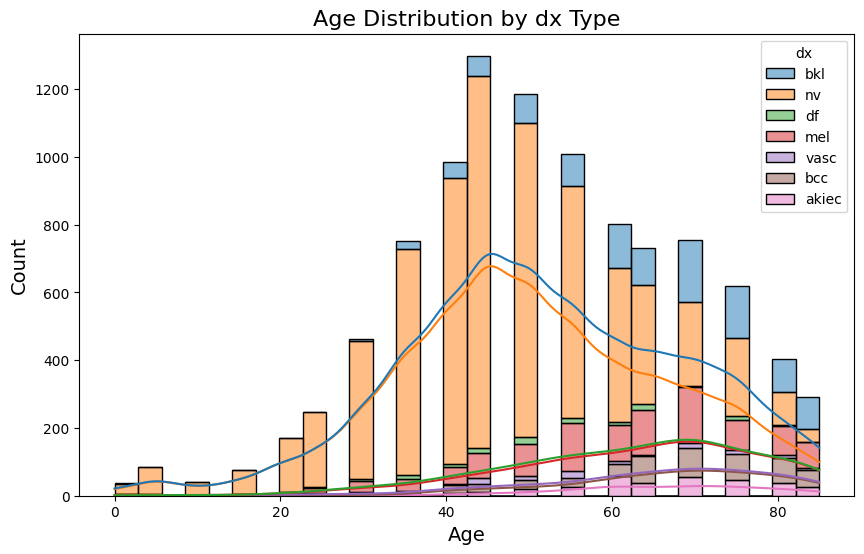

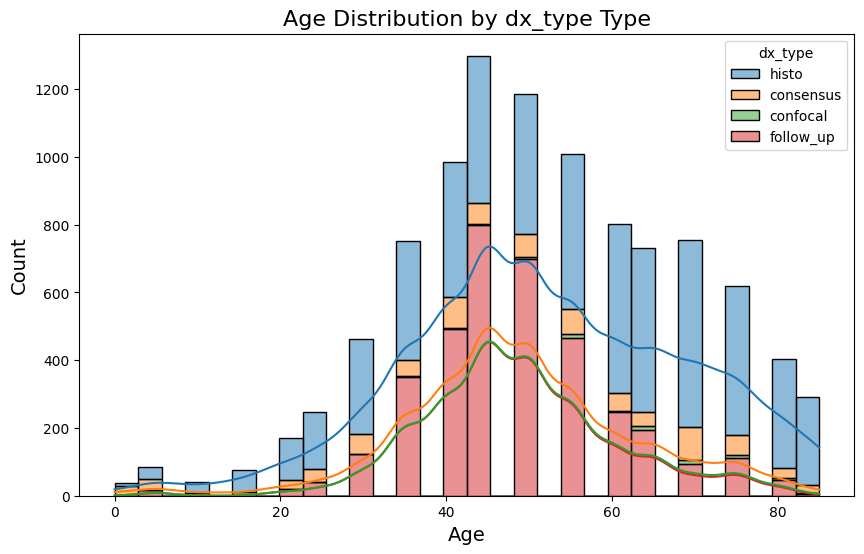

In [6]:
visualize_age_distribution( skin_df, x='age', hue=[ 'dx', 'dx_type' ] )

In [7]:
L1_series = skin_df.groupby( [ 'dx', 'dx_type' ] )[ 'age' ].transform( 'mean' ).round( 0 )
L2_series = skin_df.groupby( [ 'dx' ] )[ 'age' ].transform( 'mean' ).round( 0 )
L3_series = skin_df[ 'age' ].mean() + ( 2 * skin_df[ 'age' ].std() ).round( 0 )

In [8]:
skin_df[ 'age_imputed' ] = skin_df[ 'age' ].fillna( L1_series ).fillna( L2_series ).fillna( L3_series )

In [9]:
standard_scaler = StandardScaler()
skin_df[ 'scaled_age' ] = standard_scaler.fit_transform( skin_df[ [ 'age_imputed' ] ] )

In [10]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                           path  \
0  ..\data\raw\HAM10000_images\ISIC_0027419.jpg   
1  ..\data\raw\HAM10000_images\ISIC_0025030.jpg   
2  ..\data\raw\HAM10000_images\ISIC_0026769.jpg   
3  ..\data\raw\HAM10000_images\ISIC_0025661.jpg   
4  ..\data\raw\HAM10000_images\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  sex_code  loc_code  \
0  Benign keratosis-like lesions               2         1        11   
1  Benign keratosis-like lesions               2         1        11   
2  Benign keratosis-like lesions               2         1        11   
3  Benign keratosis-like lesions               2         1        11   
4  Benign keratosis-like lesions               2         1         4   

   age_imputed  scaled_age  
0         80.0    1.662839  
1         80.0    1.662839  
2         80.0    1.662839  
3         80.0    1.662839  
4         75.0    1.367804

## **Step 5: Splitting the DataFrame for Training and Testing**

derive only non-duplicates id for duplicate images

In [10]:
skin_df_undup = skin_df.copy()
skin_df_undup.drop_duplicates( subset=[ 'lesion_id' ], keep='first', inplace=True )

In [11]:
test_dup = skin_df.groupby( [ 'lesion_id' ] ).count()
test_dup = test_dup[ test_dup[ 'image_id' ] == 1 ]
test_dup.reset_index( inplace=True )

In [12]:
def get_duplicates( x ):
    unique_ids = list( test_dup[ 'lesion_id' ] )
    if x in unique_ids:
        return 'unduplicated'
    else:
        return 'duplicated'
    
skin_df[ 'duplicates' ] = skin_df[ 'lesion_id' ]
skin_df[ 'duplicates' ] = skin_df[ 'lesion_id' ].apply( get_duplicates )

In [13]:
skin_df_undup[  'duplicates' ] = skin_df_undup[ 'lesion_id' ].apply( get_duplicates )

In [14]:
skin_df_undup.reset_index( inplace=True, drop=True )

In [15]:
y = skin_df_undup[ 'cell_type_idx' ]
_, val_df = train_test_split( skin_df_undup, test_size=0.2, 
                             stratify=y, random_state=42 )

In [16]:
def get_val_rows( x ):
    if x in list( val_df[ 'image_id' ] ):
        return 'val'
    else:
        return 'train'

skin_df[ 'set' ] = skin_df[ 'image_id' ].apply( get_val_rows )
skin_df_undup[ 'set' ] = skin_df_undup[ 'image_id' ].apply( get_val_rows )

In [17]:
train_df = skin_df_undup[ skin_df_undup[ 'set' ] == 'train' ]

In [18]:
n_iterated = train_df[ 'cell_type_idx' ].unique().max() + 1
n_samples = train_df[ 'cell_type_idx' ].value_counts().max()

class_counts = train_df[ 'cell_type_idx' ].value_counts()

dfs_to_combine = [ train_df ]

for i in range( n_iterated ):
    multiplier = int( np.floor( n_samples / class_counts[ i ] ) )
    
    if multiplier > 0:
        subset = train_df.loc[ train_df[ 'cell_type_idx' ] == i, : ]

        copies = [ subset ] * ( multiplier - 1 )
        dfs_to_combine.extend( copies )

train_df = pd.concat( dfs_to_combine, ignore_index=True ).reset_index( drop=True )

In [19]:
train_df = train_df.reset_index( drop=True )
val_df = val_df.reset_index( drop=True )

## **Step 6: Take a look at images from both train_df and val_df**

In [20]:
train_df[ 'image' ] = train_df[ 'path' ].map(lambda x: np.asarray( Image.open( x ).resize( ( 100, 75 ) ) ) )

Show sample of images from each cancer type

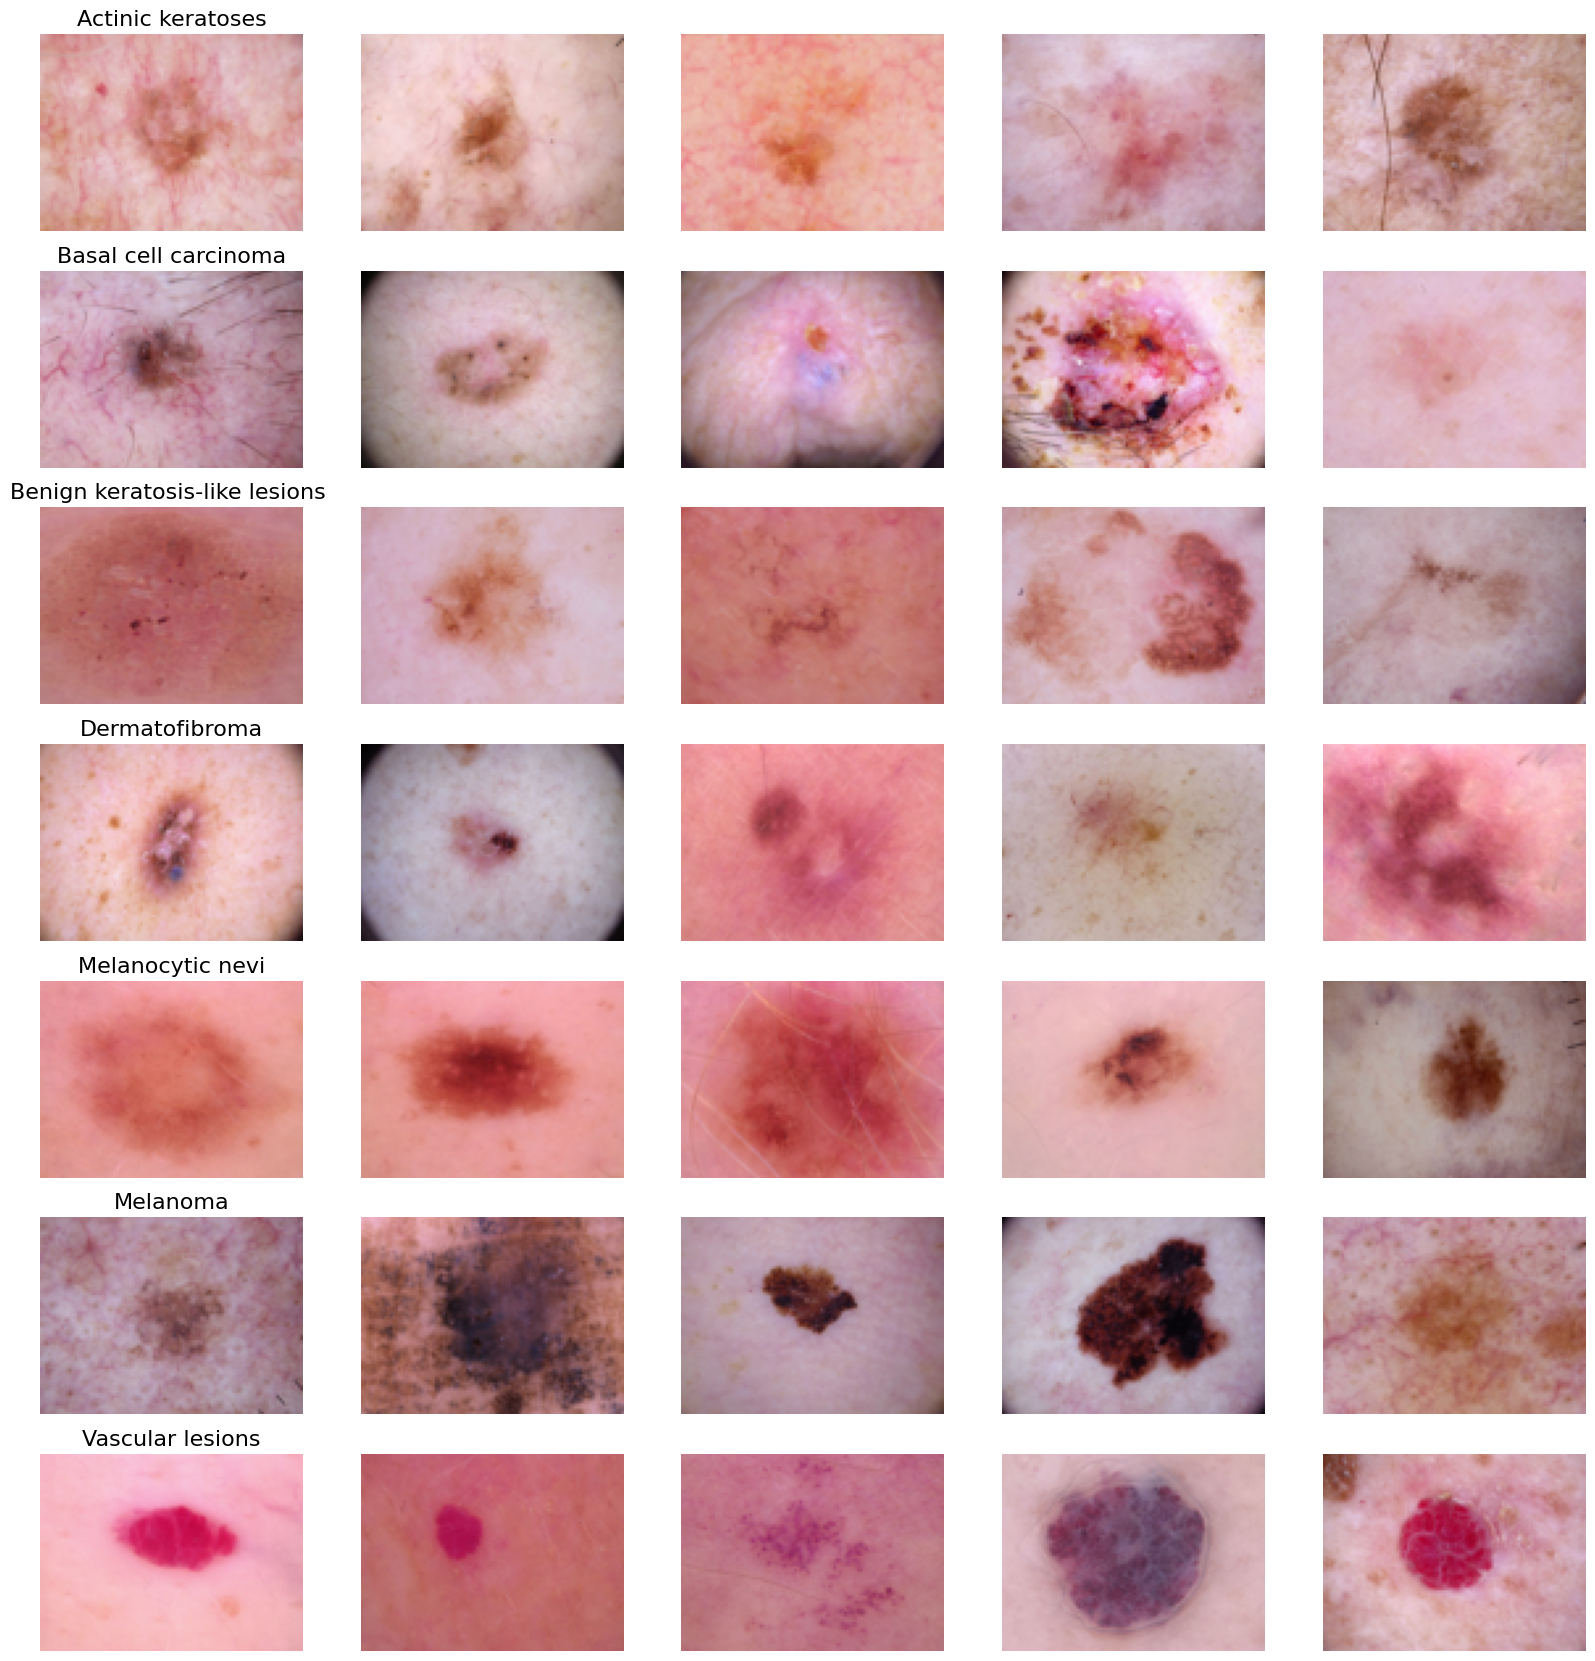

In [21]:
n_samples = 5
fig, axes = plt.subplots( len( skin_lesion_type_dict ), n_samples, figsize = ( 4 * n_samples, 3 * len( skin_lesion_type_dict ) ) )

for n_axes, ( type_name, type_rows ) in zip( axes, train_df.sort_values( [ 'cell_type' ] ).groupby( 'cell_type' ) ):
    n_axes[ 0 ].set_title( f"{ type_name }", fontsize = 16 )
    for ax, ( _, row ) in zip( n_axes, type_rows.sample( n_samples, random_state = 42 ).iterrows() ):
        ax.imshow( row[ 'image' ] )
        ax.axis( 'off' )

if not os.path.exists( "../reports/figures/" ):
    os.makedirs( "../reports/figures/" )

fig.savefig( "../reports/figures/sample_train_skin_lesion_images.png", bbox_inches = 'tight', dpi = 300 )

In [22]:
val_df[ 'image' ] = val_df[ 'path' ].map(lambda x: np.asarray( Image.open( x ).resize( ( 100, 75 ) ) ) )

Show sample of images from each cancer type

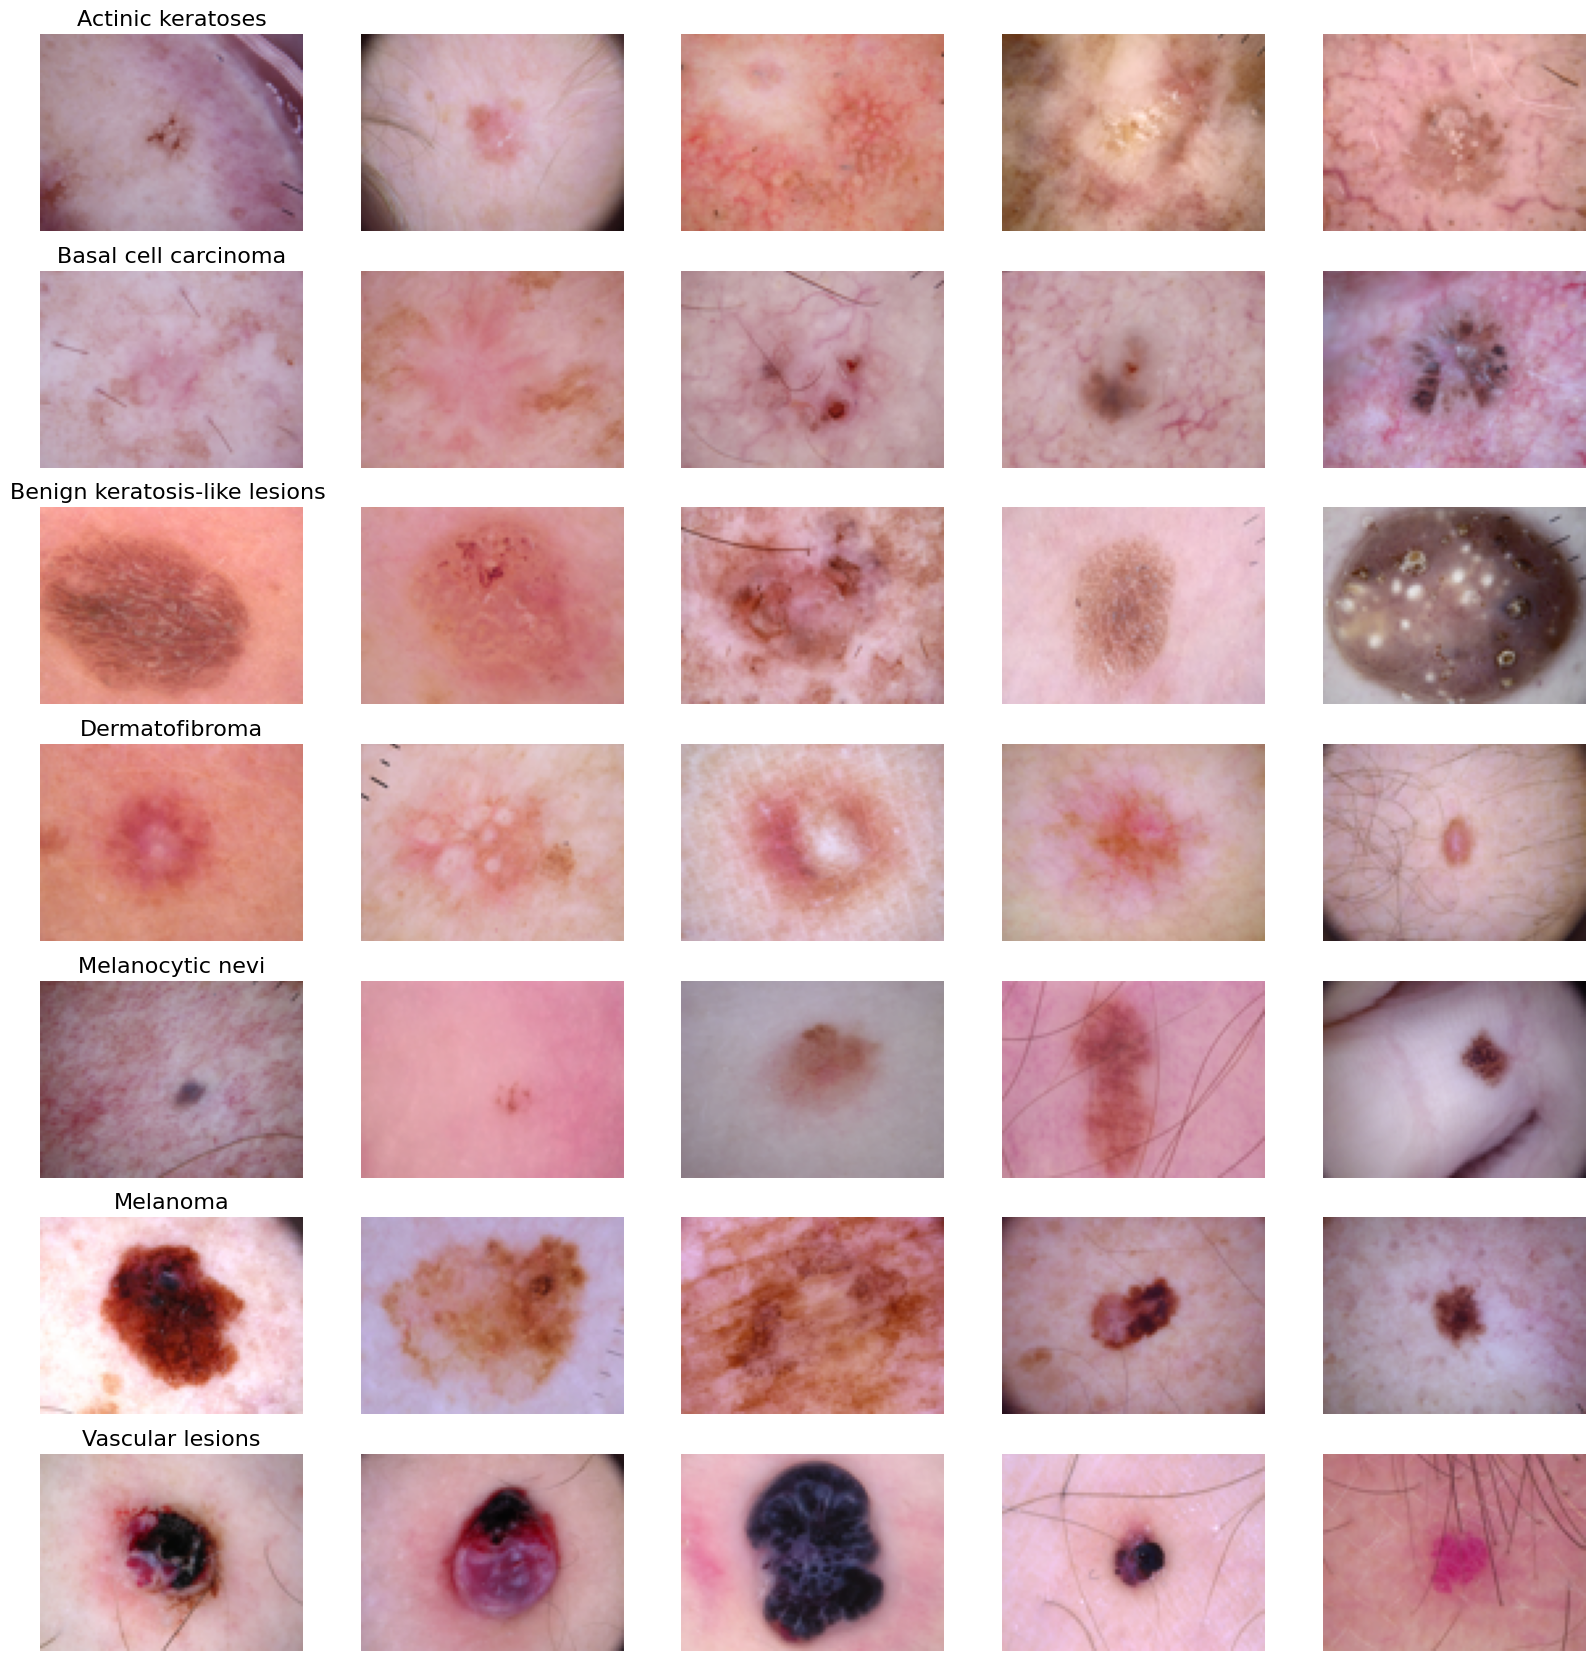

In [23]:
n_samples = 5
fig, axes = plt.subplots( len( skin_lesion_type_dict ), n_samples, figsize = ( 4 * n_samples, 3 * len( skin_lesion_type_dict ) ) )

for n_axes, ( type_name, type_rows ) in zip( axes, val_df.sort_values( [ 'cell_type' ] ).groupby( 'cell_type' ) ):
    n_axes[ 0 ].set_title( f"{ type_name }", fontsize = 16 )
    for ax, ( _, row ) in zip( n_axes, type_rows.sample( n_samples, random_state = 42 ).iterrows() ):
        ax.imshow( row[ 'image' ] )
        ax.axis( 'off' )

if not os.path.exists( "../reports/figures/" ):
    os.makedirs( "../reports/figures/" )

fig.savefig( "../reports/figures/sample_val_skin_lesion_images.png", bbox_inches = 'tight', dpi = 300 )

In [24]:
train_df.drop( columns=[ 'image' ], inplace=True )

In [25]:
val_df.drop( columns=[ 'image' ], inplace=True )

## **Step 7: Feed into the PyTorch Class**

In [26]:
torch.__version__

'2.9.0+cu130'

In [27]:
torch.cuda.is_available()

True

Class for MultiModalDataset

In [ ]:
def set_parameter_requires_grad( model, feature_extracting: bool ):
    """
        param: feature_extraicting - A boolean flag that indicates whether we are finetuning the model or feature extracting.
        This function sets the feature_extracting in the model to False when the model is finetuned and all the model 
        parameters are updated. If the feature_extracting flag is True, then only the last layer parameters are updated 
        and the rest remain fixed.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
class MultiModalDataset( Dataset ):
    """
        A custom Dataset class for loading multi-modal data including images and tabular data.
    """

    def __init__( self, dataframe: pd.DataFrame, transform = None ):
        self.df = dataframe
        self.transform = transform

        self.path = dataframe[ 'path' ].values

        self.scaled_age = dataframe[ 'scaled_age' ].values
        self.sex_code = dataframe[ 'sex_code' ].values
        self.location_code = dataframe[ 'loc_code' ].values

        self.y = dataframe[ 'cell_type_idx' ].values

    def __getitem__( self, idx ):

        image = Image.open( self.path[ idx ] ).convert( 'RGB' )
        if self.transform:
            image = self.transform( image )
        
        # Numerical Features
        scaled_age = torch.tensor( self.scaled_age[ idx ], dtype=torch.float32 )

        # Categorical Features
        # sex_code = torch.tensor( self.sex_code[ idx ], dtype=torch.long )
        # location_code = torch.tensor( self.location_code[ idx ], dtype=torch.long )

        y = torch.tensor( self.y[ idx ], dtype=torch.long )


        


        return { 
            'image': image, 
            'meta_numerical': scaled_age, 
            # sex_code, 
            # location_code, 
            'y': y
            }
    
    def __len__( self ):
        return len( self.df )

In [ ]:
class TabularFeatureExtractor( nn.Module ):
    def __init__( self, input_dim, output_dim ):
        super( TabularFeatureExtractor, self ).__init__()
        self.net = nn.Sequential(
            nn.Linear
        )

In [ ]:
train_transform = transforms.Compose( [ 
        transforms.Resize( ( 224, 224 ) ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation( 20 ),
        transforms.ColorJitter( brightness=0.1, contrast=0.1, hue=0.1 ),
        transforms.ToTensor(),
        transforms.Normalize( mean=[ 0.49139968, 0.48215827, 0.44653124 ], std=[ 0.24703233, 0.24348505, 0.26158768 ] )
     ] )

val_transform = transforms.Compose( [ 
        transforms.Resize( ( 224, 224 ) ),
        transforms.ToTensor(),
        transforms.Normalize( mean=[ 0.49139968, 0.48215827, 0.44653124 ], 
                             std=[ 0.24703233, 0.24348505, 0.26158768 ] ) 
    ] )

In [ ]:
# def conv_block( input_size, output_size ):
#     block = nn.Sequential(
#         nn.Conv2d( input_size, output_size, ( 3, 3 ) ),
#         nn.ReLU(),
#         nn.BatchNorm2d( output_size ),
#         nn.MaxPool2d( ( 2, 2 ) )
#     )
#     return block

In [ ]:
training_set = MultiModalDataset( dataframe=train_df, transform=train_transform )
train_loader = DataLoader( training_set, batch_size=32, shuffle=True, num_workers=4 )

val_set = MultiModalDataset( dataframe=val_df, transform=val_transform )
val_loader = DataLoader( val_set, batch_size=32, shuffle=True, num_workers=4 )

In [ ]:
optimizer = optim.Adam( params=, lr=1e-3 )